In [1]:
import functools
import itertools
import os
import shutil
import sys
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from estimagic import minimize
from estimagic.batch_evaluators import joblib_batch_evaluator
from estimagic.optimization.process_constraints import process_constraints
from estimagic.visualization.colors import get_colors
from matplotlib.dates import DateFormatter
from sid import get_msm_func, get_simulate_func
from sid.msm import get_diag_weighting_matrix

from src.calculate_moments import (
    smoothed_outcome_per_hundred_thousand_rki,
    smoothed_outcome_per_hundred_thousand_sim,
)
from src.config import BLD, SRC
from src.contact_models.get_contact_models import get_all_contact_models
from src.create_initial_states.create_initial_conditions import (  # noqa
    create_initial_conditions,
)
from src.manfred.minimize_manfred_estimagic import minimize_manfred_estimagic
from src.manfred.shared import hash_array
from src.plotting.plot_msm_performance import plot_msm_performance
from src.plotting.policy_gantt_chart import make_gantt_chart_of_policy_dict
from src.policies.combine_policies_over_periods import get_estimation_policies
from src.policies.full_policy_blocks import (
    get_german_reopening_phase,
    get_hard_lockdown,
    get_only_educ_closed,
    get_soft_lockdown,
)
from src.policies.policy_tools import combine_dictionaries

In [2]:
ESTIMATION_START = pd.Timestamp("2020-10-01")
ESTIMATION_END = pd.Timestamp("2020-12-12")

INIT_START = ESTIMATION_START - pd.Timedelta(31, unit="D")
INIT_END = ESTIMATION_START - pd.Timedelta(1, unit="D")
initial_states = pd.read_parquet(BLD / "data" / "initial_states.parquet")
share_known_cases = pd.read_pickle(
    BLD / "data" / "processed_time_series" / "share_known_cases.pkl"
)

In [3]:
initial_conditions = create_initial_conditions(
    start=INIT_START,
    end=INIT_END,
    seed=3484,
    reporting_delay=5,
)

In [4]:
contact_models = get_all_contact_models(
    christmas_mode=None, n_extra_contacts_before_christmas=None
)

In [5]:
params = pd.read_pickle(SRC / "simulation" / "estimated_params.pkl")

In [6]:
def parallelizable_simulate_func(
    params,
    initial_states,
    initial_conditions,
    prefix,
    share_known_cases,
    seed,
):

    params_hash = hash_array(params["value"].to_numpy())
    path = SRC / "exploration" / f"{prefix}_{params_hash}_{os.getpid()}_{seed}"

    contact_models = get_all_contact_models(
        christmas_mode=None, n_extra_contacts_before_christmas=None
    )

    estimation_policies = get_estimation_policies(contact_models)

    simulate = get_simulate_func(
        params=params,
        initial_states=initial_states,
        contact_models=contact_models,
        contact_policies=estimation_policies,
        duration={"start": ESTIMATION_START, "end": ESTIMATION_END},
        initial_conditions=initial_conditions,
        share_known_cases=share_known_cases,
        path=path,
        seed=seed,
        saved_columns={
            "initial_states": ["age_group_rki"],
            "disease_states": ["newly_infected"],
            "time": ["date"],
            "other": ["new_known_case"],
        },
    )

    res = simulate(params)
    return res


simulate = functools.partial(
    parallelizable_simulate_func,
    initial_states=initial_states,
    initial_conditions=initial_conditions,
    prefix="fitness_plots",
    share_known_cases=share_known_cases,
)

In [7]:
seeds = [100_000 * i for i in range(5)]
arguments = [{"params": params, "seed": seed} for seed in seeds]


results = joblib_batch_evaluator(
    simulate,
    arguments,
    n_cores=5,
    unpack_symbol="**",
)

In [8]:
rki_data = pd.read_pickle(BLD / "data" / "processed_time_series" / "rki.pkl")
rki_data = (
    rki_data.loc[ESTIMATION_START:ESTIMATION_END].groupby("date").sum().reset_index()
)


shifted_rki_data = pd.read_pickle(BLD / "data" / "processed_time_series" / "rki.pkl")
shifted_rki_data = shifted_rki_data.groupby("date").sum().reset_index()
shifted_rki_data["date"] = shifted_rki_data["date"] - pd.Timedelta(days=6)
shifted_rki_data = shifted_rki_data.set_index("date")
shifted_rki_data = shifted_rki_data.loc[ESTIMATION_START:ESTIMATION_END]
shifted_rki_data = shifted_rki_data.reset_index()


rki_incidence_per_day = smoothed_outcome_per_hundred_thousand_rki(
    df=rki_data,
    outcome="newly_infected",
    take_logs=False,
    window=7,
)
rki_weekly_incidence = 7 * rki_incidence_per_day

upscaled_incidence_per_day = smoothed_outcome_per_hundred_thousand_rki(
    df=shifted_rki_data,
    outcome="upscaled_newly_infected",
    take_logs=False,
    window=7,
)

upscaled_weekly_incidence = 7 * upscaled_incidence_per_day

In [9]:
sim_known_weekly_incidences = []
for res in results:
    sim_known_weekly_incidences.append(
        smoothed_outcome_per_hundred_thousand_sim(
            df=res["time_series"],
            outcome="new_known_case",
            take_logs=False,
            window=7,
        )
        * 7
    )

mean_sim_known_weekly_incidence = pd.concat(sim_known_weekly_incidences, axis=1).mean(
    axis=1
)


sim_true_weekly_incidences = []
for res in results:
    sim_true_weekly_incidences.append(
        smoothed_outcome_per_hundred_thousand_sim(
            df=res["time_series"],
            outcome="newly_infected",
            take_logs=False,
            window=7,
        )
        * 7
    )

mean_sim_true_weekly_incidence = pd.concat(sim_true_weekly_incidences, axis=1).mean(
    axis=1
)

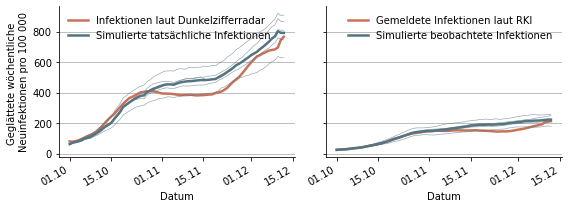

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3), sharex=True, sharey=True)
colors = get_colors("ordered", 2)

labels = ["Simulierte tatsächliche Infektionen", "Simulierte beobachtete Infektionen"]

sns.lineplot(
    x=upscaled_weekly_incidence.index,
    y=upscaled_weekly_incidence,
    ax=axes[0],
    color=colors[1],
    label="Infektionen laut Dunkelzifferradar",
    linewidth=2.5,
)

sns.lineplot(
    x=rki_weekly_incidence.index,
    y=rki_weekly_incidence,
    ax=axes[1],
    color=colors[1],
    label="Gemeldete Infektionen laut RKI",
    linewidth=2.5,
)

for i, sim_cases_list in enumerate(
    [sim_true_weekly_incidences, sim_known_weekly_incidences]
):
    mean_cases = pd.concat(sim_cases_list, axis=1).mean(axis=1)
    sns.lineplot(
        x=mean_cases.index,
        y=mean_cases,
        ax=axes[i],
        color=colors[0],
        label=labels[i],
        linewidth=2.5,
    )
    for cases in sim_cases_list:
        sns.lineplot(
            x=cases.index,
            y=cases,
            ax=axes[i],
            color=colors[0],
            linewidth=0.7,
            alpha=0.6,
        )

date_form = DateFormatter("%d.%m")

for ax in axes:
    ax.set_ylabel("")
    ax.set_xlabel("Datum")
    ax.xaxis.set_major_formatter(date_form)
    fig.autofmt_xdate()
    ax.set_ylabel("Geglättete wöchentliche \nNeuinfektionen pro 100 000")
    ax.grid(axis="y")

fig.tight_layout()

In [11]:
fig.savefig("fitness_plot.png", dpi=200)